# Medical Image Classification with MONAI

In [71]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.45.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [9]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [10]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [11]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [12]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

In [13]:
class _3D_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        return {'images': data, 'label': label}

In [14]:
train_dataset_ = _3D_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = _3D_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = _3D_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Training cycle

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=3, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [66]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.7488
2/30, train_loss: 2.4562
3/30, train_loss: 2.3348
4/30, train_loss: 2.2509
5/30, train_loss: 2.2207
6/30, train_loss: 1.9836
7/30, train_loss: 2.0278
8/30, train_loss: 1.8347
9/30, train_loss: 1.8846
10/30, train_loss: 1.7019
11/30, train_loss: 1.6682
12/30, train_loss: 1.3827
13/30, train_loss: 1.6103
14/30, train_loss: 1.7344
15/30, train_loss: 1.7045
16/30, train_loss: 1.5434
17/30, train_loss: 1.6068
18/30, train_loss: 1.2270
19/30, train_loss: 1.7040
20/30, train_loss: 1.4963
21/30, train_loss: 1.7310
22/30, train_loss: 1.3564
23/30, train_loss: 1.4337
24/30, train_loss: 1.2748
25/30, train_loss: 1.0866
26/30, train_loss: 1.7901
27/30, train_loss: 1.3725
28/30, train_loss: 1.2210
29/30, train_loss: 1.0637
30/30, train_loss: 1.3348
31/30, train_loss: 1.2261
epoch 1 average loss: 1.6778
1
saved new best metric model
current epoch: 1 current AUC: 0.5808 current accuracy: 0.0994 best AUC: 0.5808 at epoch: 1
----------
epoch 2/100
1/30, t

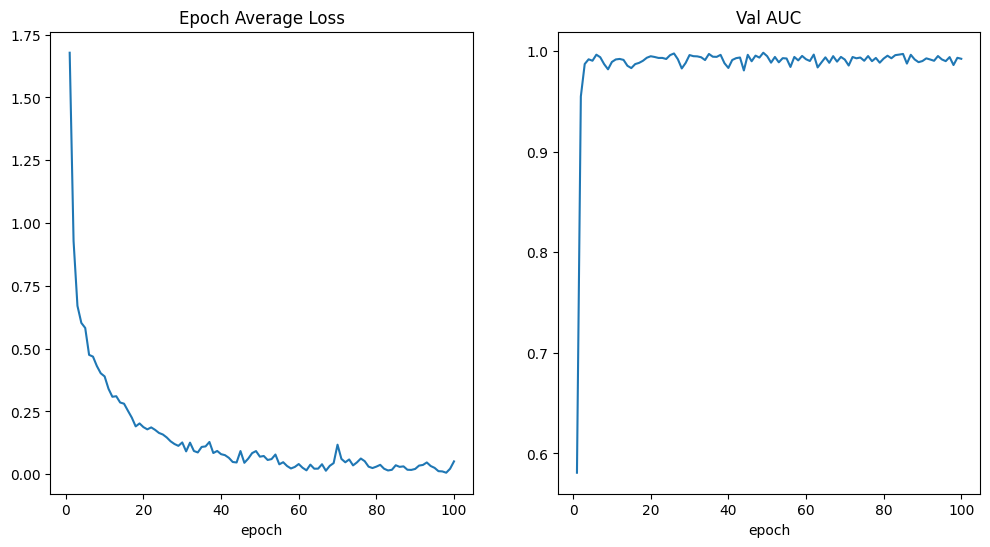

In [67]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [68]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [69]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.6900    1.0000    0.8166        69
           1     0.6491    0.5441    0.5920        68
           2     0.7059    0.5217    0.6000        69
           3     0.5741    0.4769    0.5210        65
           4     0.5634    0.6154    0.5882        65
           5     0.8312    0.9697    0.8951        66
           6     0.9200    0.8214    0.8679        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8947    0.4928    0.6355        69
          10     0.7053    0.9710    0.8171        69

    accuracy                         0.7262       610
   macro avg     0.7758    0.7648    0.7576       610
weighted avg     0.7335    0.7262    0.7143       610



## Pretrained model

## Training cycle

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True, spatial_dims=3, n_input_channels=1, 
                 feed_forward=False, shortcut_type='A', bias_downsample=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [56]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [57]:
model.avgpool = nn.Sequential(
    model.avgpool,
    nn.Flatten(),
    nn.Linear(512, n_classes)
).to(device)

In [58]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.6332
2/30, train_loss: 2.6579
3/30, train_loss: 2.4664
4/30, train_loss: 2.6320
5/30, train_loss: 2.2822
6/30, train_loss: 2.3380
7/30, train_loss: 2.3262
8/30, train_loss: 2.2968
9/30, train_loss: 2.3607
10/30, train_loss: 2.2917
11/30, train_loss: 2.3346
12/30, train_loss: 2.3232
13/30, train_loss: 2.2657
14/30, train_loss: 2.0570
15/30, train_loss: 2.0150
16/30, train_loss: 2.0180
17/30, train_loss: 1.9785
18/30, train_loss: 2.0204
19/30, train_loss: 2.0272
20/30, train_loss: 1.9808
21/30, train_loss: 1.9382
22/30, train_loss: 2.0246
23/30, train_loss: 1.8976
24/30, train_loss: 1.8239
25/30, train_loss: 1.8178
26/30, train_loss: 1.7795
27/30, train_loss: 1.8008
28/30, train_loss: 1.5290
29/30, train_loss: 1.8498
30/30, train_loss: 1.6670
31/30, train_loss: 1.8082
epoch 1 average loss: 2.1046
1
saved new best metric model
current epoch: 1 current AUC: 0.7054 current accuracy: 0.1677 best AUC: 0.7054 at epoch: 1
----------
epoch 2/100
1/30, t

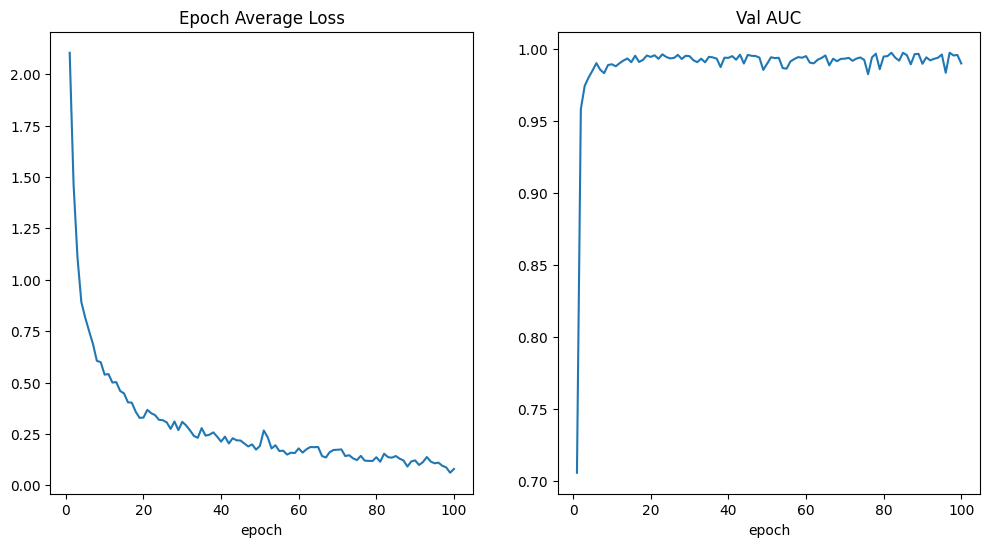

In [59]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [61]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [62]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6667    0.6176    0.6412        68
           2     0.6528    0.6812    0.6667        69
           3     0.5926    0.2462    0.3478        65
           4     0.5204    0.7846    0.6258        65
           5     0.8889    0.9697    0.9275        66
           6     0.9000    0.9643    0.9310        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9420    0.9420    0.9420        69
          10     0.9254    0.8986    0.9118        69

    accuracy                         0.7951       610
   macro avg     0.8250    0.8276    0.8170       610
weighted avg     0.7958    0.7951    0.7846       610

